# Heart Disease Report

The dataset used in this report is the Cleveland processed dataset which can be found in the data folder here: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

The objective of this study is to apply a classifer to the dataset to predict whether an individual has heart disease.

In [8]:
import seaborn as sns
from heart_disease import DataLoader

In [13]:
Loader = DataLoader()
dataset = Loader.dataset

2021-02-20 17:03:37 INFO Data Loader: Initialise Data Loader
2021-02-20 17:03:38 INFO Data Loader: Dataset loaded: 14 columns, 303 rows
2021-02-20 17:03:38 INFO Data Loader: 2 missing values in Thal, replaced with 3.0 (= normal).
2021-02-20 17:03:38 INFO Data Loader: 4 missing values in Number of Major Vessels, replaced with 0.0 (= mode).


In [14]:
dataset.describe(include="all")

,Age,Sex,Resting Blood Pressure,Cholestoral,Fasting Blood Sugar,Maximum Heart Rate,Exercise Induced Angina,ST Depression,Number of Major Vessels,Chest Pain Typical,...,Resting ECG Normal,Resting ECG Abnormal,Resting ECG Hypertrophy,Peak Exercise Slope Up,Peak Exercise Slope Flat,Peak Exercise Slope Down,Thal Normal,Thal Fixed Defect,Thal Reversable Defect,Heart Disease
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,...,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,0.529978,0.679868,0.355564,0.275555,0.148515,0.600055,0.326733,0.167678,0.221122,0.075908,...,0.498350,0.013201,0.488449,0.468647,0.462046,0.069307,0.554455,0.059406,0.386139,0.458746
std,0.188305,0.467299,0.166035,0.118212,0.356198,0.174618,0.469794,0.187270,0.311458,0.265288,...,0.500824,0.114325,0.500693,0.499842,0.499382,0.254395,0.497848,0.236774,0.487668,0.499120
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.395833,0.000000,0.245283,0.194064,0.000000,0.477099,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.562500,1.000000,0.339623,0.262557,0.000000,0.625954,0.000000,0.129032,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.666667,1.000000,0.433962,0.340183,0.000000,0.725191,1.000000,0.258065,0.333333,0.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Explore the data

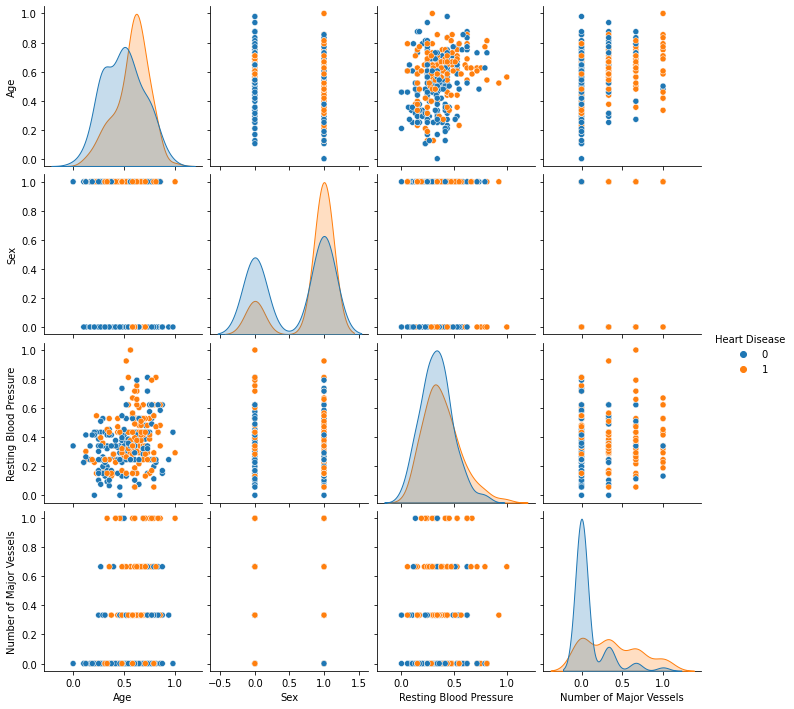

In [16]:
sns.pairplot(data=dataset, hue="Heart Disease", vars=["Age", "Sex", "Resting Blood Pressure", "Number of Major Vessels"])